## Using a PACDataFrame for PAC in Spark

First, we set up our Spark session and import the data.

In [1]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import lower, col, count, concat_ws
from pyspark.sql.types import Row
from pyspark import RDD
from typing import List, Tuple, Callable, Dict, Optional, Any, NamedTuple
import numpy as np
import scipy.stats as stats
from tqdm import tqdm

from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions

spark = (SparkSession.builder.appName("pacdb")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", ".spark")
         .enableHiveSupport()
         .getOrCreate())

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

24/03/07 14:19:30 WARN Utils: Your hostname, laelaps-4.local resolves to a loopback address: 127.0.0.1; using 10.138.204.148 instead (on interface en0)
24/03/07 14:19:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/07 14:19:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
lung_df = spark.read.parquet("./data/lung.parquet")
#lung_df.write.saveAsTable("lung", mode="overwrite") # for SQL queries

smokers = lung_df.filter(lung_df["Smoking"] >= 3) # Smoking is on 1-7 scale
smokers.count()

597

#### Create PACDataFrame

In [3]:
# 0. Do all joins, etc. to get the data you want into a single Spark DataFrame. Turn it into a PACDataFrame.
spark_df: DataFrame = lung_df
pac_lung_df: PACDataFrame = PACDataFrame(lung_df)
               
# Define your query as a function that takes a DataFrame and returns (for now) an integer
def A(x: DataFrame) -> int:
    """Query to make private, $A(x)$ in the PAC-ML paper."""
    y = (x.filter(lung_df["Smoking"] >= 3)
             .count())
    return y

# Attach the predicate function to the PACDataFrame
pac_lung_df = pac_lung_df.withPredicate(A)

#### 1. Sampling
Set the sampler options on the PACDataFrame, then call the sample method to sample the data. The samples constitute $X$.

In the future, the sample method will be called internally by PACDataFrame such that the user does not need to handle the inputs ($X$) or outputs ($Y$) but rather only needs to set parameters and issue a query.

In [4]:
# 1. Sampling
# Set sampler options on the PACDataFrame
pac_lung_df = pac_lung_df.withSamplerOptions(
                    SamplerOptions(
                        withReplacement=False, 
                        fraction=0.5
                    )
                )

trials = 200
X: List[DataFrame] = [pac_lung_df.sample() for i in range(trials * 2)]

#### 2. Measure Stability

Run the inputs through the mechanism function to get the outputs, which constitute $Y$.

$Y_i = \mathcal{A}(X_i)$ for all $X_i \in X$

In [5]:
# 2. Measure Stability

# Eventually this should become something like PACDataFrame.analyze()
# The challenge is how to handle the way that sampling affects the outcome of the predicate
# for all predicate types: i.e. we need to multiply to cancel out sampling rate for count and sum

Y: list[int] = []

for Xi in X:
    Yi = pac_lung_df._applyPredicate(Xi)
    Yi = Yi * (1/pac_lung_df.sampling_rate)  # so that counts are not halved
    Y.append(Yi)  # store result of query

Y_pairs = list(zip(Y[::2], Y[1::2]))

100%|██████████| 400/400 [00:55<00:00,  7.21it/s]


These are the samples that we have:

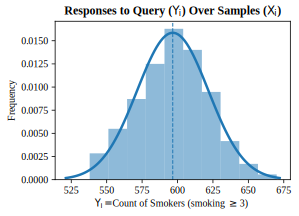

In [111]:
# Plot histogram of samples
fig, ax = plt.subplots(figsize=(6.4*(2/3), 4.8*(2/3)))
plt.hist(Y, bins=10, density=True, alpha=0.5, color='tab:blue')

mu = np.mean(Y)
sigma = np.std(Y)

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color='tab:blue', linewidth=2.5)
plt.axvline(mu, color='tab:blue', linestyle='dashed', linewidth=1)

plt.title('Responses to Query ($Y_i$) Over Samples ($X_i$)')
plt.xlabel('$Y_i = $Count of Smokers (smoking $\geq$ 3) ')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("figs/samples.png")

In [7]:
{'mean': mu, 'variance': sigma**2, 'covariance': np.cov(Y, Y)}

{'mean': 596.635,
 'variance': 632.726775,
 'covariance': array([[634.31255639, 634.31255639],
        [634.31255639, 634.31255639]])}

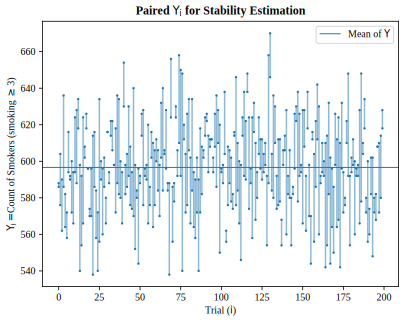

In [21]:
# plot sample points
plt.scatter(range(len(Y_pairs)), [sp[0] for sp in Y_pairs], alpha=1, color='tab:blue', s=2)
plt.scatter(range(len(Y_pairs)), [sp[1] for sp in Y_pairs], alpha=1, color='tab:blue', s=2)
for i, sp in enumerate(Y_pairs):
    plt.plot([i, i], [sp[0], sp[1]], color='tab:blue', alpha=0.5, lw=1.5)

# depict mean as a line
plt.axhline(y=np.mean(Y), color='tab:blue', linestyle='-', lw=1, label='Mean of $Y$')
plt.title('Paired $Y_i$ for Stability Estimation')
plt.xlabel('Trial ($i$)')
plt.ylabel('$Y_i = $Count of Smokers (smoking $\geq$ 3)')
# min y axis must be 0
#plt.ylim(bottom=0)
plt.legend()
plt.savefig("figs/paired-samples.png")

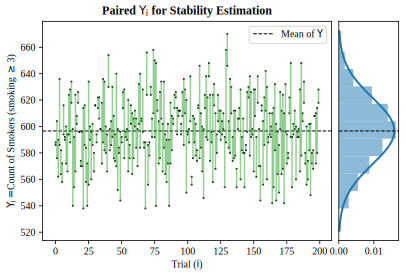

In [112]:
# plot both the histogram and the sample point intervals on the same plot, with the histogram on top and the intervals below as horizontal lines
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax.set_aspect(1.)
# plot above main plot for histogram
divider = make_axes_locatable(ax)
ax_histy = divider.append_axes("right", 1/1.2, pad=0.1, sharey=ax)
ax_histy.yaxis.set_tick_params(labelleft=False, left=False)

# plot marginal histogram
ax_histy.hist(Y, bins=10, density=True, alpha=0.5, color='tab:blue', orientation='horizontal')
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax_histy.plot(stats.norm.pdf(x, mu, sigma), x, color='tab:blue', linewidth=2)
ax_histy.axhline(mu, color='black', linestyle='dashed', linewidth=1)

# plot sample points horizontally
ax.scatter(range(len(Y_pairs)), [sp[0] for sp in Y_pairs], alpha=1, color='black', s=1)
ax.scatter(range(len(Y_pairs)), [sp[1] for sp in Y_pairs], alpha=1, color='black', s=1)
ax.axhline(mu, color='black', linestyle='dashed', linewidth=1, label='Mean of $Y$')

for i, sp in enumerate(Y_pairs):
    ax.plot([i, i], [sp[0], sp[1]], color='tab:green', alpha=0.5)

ax.set_title('Paired $Y_i$ for Stability Estimation')
ax.set_xlabel('Trial ($i$)')
ax.set_ylabel('$Y_i = $Count of Smokers (smoking $\geq$ 3)')
# min y axis must be 0
#plt.ylim(bottom=0)
(ax.legend(
    [*ax.get_legend_handles_labels()[0], *ax_histy.get_legend_handles_labels()[0]],
    [*ax.get_legend_handles_labels()[1], *ax_histy.get_legend_handles_labels()[1]]
))
fig.savefig("figs/paired-with-histogram.png")

Text(0, 0.5, 'Frequency')

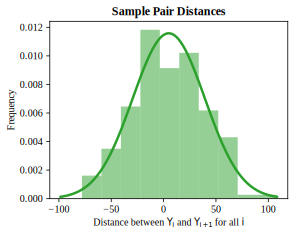

In [12]:
# plot distances of paired samples
fig, ax = plt.subplots(figsize=(6.4*(2/3), 4.8*(2/3)))
pair_distances = [sp[0]-sp[1] for sp in Y_pairs]
plt.hist(pair_distances, bins=10, density=True, alpha=0.5, color='tab:green')
plt.plot(
    np.linspace(np.mean(pair_distances) - 3*np.std(pair_distances), np.mean(pair_distances) + 3*np.std(pair_distances), 100),
    stats.norm.pdf(np.linspace(np.mean(pair_distances) - 3*np.std(pair_distances), np.mean(pair_distances) + 3*np.std(pair_distances), 100), np.mean(pair_distances), np.std(pair_distances)), color='tab:green', linewidth=2.5)
plt.title('Sample Pair Distances')
plt.xlabel('Distance between $Y_i$ and $Y_{i+1}$ for all $i$')
plt.ylabel('Frequency')

### Noise

Now we calculate the noise to add. I've attempted to construct what I need based on the PAC-ML code, but this probably has many errors.

Noise is estimated using Algorithm 2 from the PAC paper, with details taken from `rand_mechanism_noise` in the PAC-ML paper.

$\text{noise} = ((\psi + c) / (2*v))$ where $\psi$ is the average distance between paired samples and $v = \tt{max\_mi}/2$

In [ ]:
import paclib

In [47]:
# 3. Estimate Noise
c = 0.001
max_mi = 1/32  # 2 * v

# find paired distances
dists = [np.abs(sp[0] - sp[1]) for sp in Y_pairs]
avg_dist = np.mean(dists)  # psi

# At different levels of MI, compute noise to add
noise_params = []
for max_mi in [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]:
    print(f"avg_dist: {avg_dist}, c: {c}, max_mi: {max_mi:8} => {paclib.noise_to_add_parameters(avg_dist, c, max_mi)}")
    noise_params.append([
        max_mi, 
        paclib.noise_to_add_parameters(avg_dist, c, max_mi).mean, 
        paclib.noise_to_add_parameters(avg_dist, c, max_mi).variance
        ])

avg_dist: 28.09, c: 0.001, max_mi: 0.015625 => GaussianDistribution(mean=0, variance=1797.824)
avg_dist: 28.09, c: 0.001, max_mi:  0.03125 => GaussianDistribution(mean=0, variance=898.912)
avg_dist: 28.09, c: 0.001, max_mi:   0.0625 => GaussianDistribution(mean=0, variance=449.456)
avg_dist: 28.09, c: 0.001, max_mi:    0.125 => GaussianDistribution(mean=0, variance=224.728)
avg_dist: 28.09, c: 0.001, max_mi:     0.25 => GaussianDistribution(mean=0, variance=112.364)
avg_dist: 28.09, c: 0.001, max_mi:      0.5 => GaussianDistribution(mean=0, variance=56.182)
avg_dist: 28.09, c: 0.001, max_mi:      1.0 => GaussianDistribution(mean=0, variance=28.091)
avg_dist: 28.09, c: 0.001, max_mi:      2.0 => GaussianDistribution(mean=0, variance=14.0455)
avg_dist: 28.09, c: 0.001, max_mi:      4.0 => GaussianDistribution(mean=0, variance=7.02275)


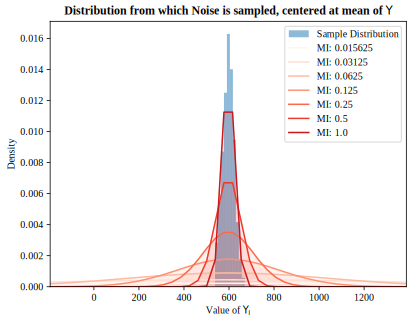

In [45]:
# plot original sample distribution
plt.hist(Y, bins=10, density=True, alpha=0.5, color='tab:blue', label="Sample Distribution")

sm = np.mean(Y)
sv = np.var(Y)

# colors = reds
colors = plt.cm.Reds(np.linspace(0, 1, len(noise_params)))

# for each mi, plot the normal distribution centered at mean with variance. have mis as legend
for (max_mi, mean, variance), c in zip(noise_params[:7], colors):
    mean = sm
    x = np.linspace(mean - 3*sv, mean + 3*sv, 100)
    plt.plot(x, stats.norm.pdf(x, mean, variance), label=f"MI: {max_mi}", color=c)
    plt.fill_between(x, stats.norm.pdf(x, mean, variance), alpha=0.1, color=c)

# set x axis to be the same as the original sample distribution
plt.xlim([sm - 1.25*sv, sm + 1.25*sv])
plt.title('Distribution from which Noise is sampled, centered at mean of $Y$')
plt.ylabel('Density')
plt.xlabel('Value of $Y_i$')
plt.legend()
plt.savefig("figs/noise.png")

In [113]:
# 4. Noised Release

# obtain one more sample to use for noised release
Yj = pac_lung_df._applyPredicate(pac_lung_df.sample()) * 2
print(Yj)

c = 0.001
mi = 1/16

noise_to_add = paclib.noise_to_add(avg_dist, c, mi)
print(noise_to_add)

noised_Yj = Yj + noise_to_add
noised_Yj

582
-87.8347080125193


494.1652919874807

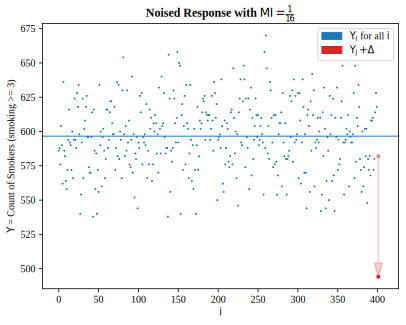

In [99]:
# plot samples
plt.scatter(range(len(Y)), Y, alpha=1, color='tab:blue', s=1)
plt.axhline(y=np.mean(Y), color='tab:blue', linestyle='-', lw=1)

# plot noised response
plt.scatter([len(Y)+1], [Yj], alpha=0.4, color='tab:red', s=10)
plt.scatter([len(Y)+1], [noised_Yj], alpha=1, color='tab:red', s=10)
# plot arrow from sample to noised response
plt.arrow(len(Y)+1, Yj, 0, noised_Yj-Yj, color='tab:red', alpha=0.2, length_includes_head=True, head_width=10, head_length=10, lw=2)

plt.title('Noised Response with $MI = \\frac{1}{16}$')
plt.xlabel('$i$')
plt.ylabel('$Y$ = Count of Smokers (smoking >= 3)')
plt.legend(handles=[mpatches.Patch(color='tab:blue', label='$Y_i$ for all $i$'), mpatches.Patch(color='tab:red', label='$Y_j + \\Delta$')])
#plt.ylim(bottom=0)
plt.savefig("figs/original-vs-noised.png")

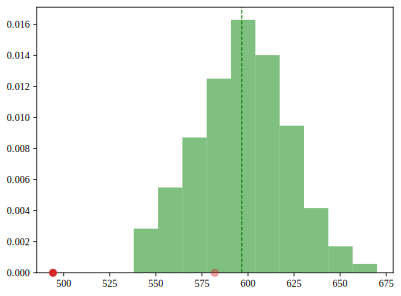

In [100]:
# plot noised response on original distribution
plt.hist(Y, bins=10, density=True, alpha=0.5, color='g')
plt.axvline(mu, color='g', linestyle='dashed', linewidth=1)

plt.scatter([Yj], [0], alpha=0.4, color='tab:red', s=50, zorder=10, clip_on=False)
plt.scatter([noised_Yj], [0], alpha=1, color='tab:red', s=50, zorder=10, clip_on=False)

### Multiple Tables

In [3]:
# Split the lung table into multiple tables over Patient Id
identity_df: DataFrame = lung_df.select("Name", "index", "Patient Id", "Age", "Gender")
identity_df.write.saveAsTable("identity", mode="overwrite")

symptoms_df: DataFrame = lung_df.select("Patient Id", "Chest Pain", "Coughing of Blood", "Fatigue", "Weight Loss", "Shortness of Breath", "Wheezing", "Swallowing Difficulty", "Clubbing of Finger Nails", "Frequent Cold", "Dry Cough", "Snoring")
symptoms_df.write.saveAsTable("symptoms", mode="overwrite")

risk_factors_df: DataFrame = lung_df.select("Patient Id", "Air Pollution", "Alcohol use", "Dust Allergy", "Occupational Hazards", "Genetic Risk", "Chronic Lung Disease", "Balanced Diet", "Obesity", "Smoking", "Passive Smoker")
risk_factors_df.write.saveAsTable("risk_factors", mode="overwrite")

24/03/07 14:19:42 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/03/07 14:19:42 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/03/07 14:19:45 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
24/03/07 14:19:45 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore michael@127.0.0.1
24/03/07 14:19:46 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
24/03/07 14:19:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/03/07 14:19:50 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/03/07 14:19:50 WARN HiveConf:

In [17]:
# Count the number of patients in each age group with chest pain who are smokers
spark.sql("""
        SELECT FLOOR(identity.Age / 10) * 10 AS Age_Group, COUNT(*) AS Count
        FROM identity
        JOIN symptoms ON identity.`Patient Id` = symptoms.`Patient Id`
        JOIN risk_factors ON identity.`Patient Id` = risk_factors.`Patient Id`
        WHERE risk_factors.Smoking >= 3
          AND symptoms.`Chest Pain` > 1
        GROUP BY FLOOR(identity.Age / 10) * 10
        ORDER BY Age_Group
        """).toPandas()

,Age_Group,Count
0,10,28
1,20,106
2,30,222
3,40,120
4,50,30
5,60,31
6,70,10


In [18]:
# spark_df: DataFrame = (identity_df.join(symptoms_df, "Patient Id") # First do all the joins
#                  .join(risk_factors_df, "Patient Id"))
# spark_df.count()

1000

In [34]:
# 0. Do all joins, etc. to get the data you want into a single Spark DataFrame. Turn it into a PACDataFrame.
spark_df: DataFrame = (identity_df.join(symptoms_df.filter(symptoms_df["Chest Pain"] > 1), "Patient Id") # First do all the joins
                 .join(risk_factors_df.filter(risk_factors_df["Smoking"] >= 3) , "Patient Id") # N
        )
pac_lung_df: PACDataFrame = PACDataFrame(lung_df)
               
# Define your query as a function that takes a DataFrame and returns (for now) an integer
def A(x: DataFrame) -> int:
    """Function to make private"""
    y = (x
        .withColumn("Age_Group", (x["Age"] / 10).cast("int") * 10)
        .groupBy("Age_Group")
        .count()
        .orderBy("Age_Group"))
    return y

# Attach the predicate function to the PACDataFrame
pac_lung_df = pac_lung_df.withPredicate(A)

In [35]:
# 1. Sampling
# Set sampler options on the PACDataFrame
pac_lung_df = pac_lung_df.withSamplerOptions(
                    SamplerOptions(
                        withReplacement=False, 
                        fraction=0.5
                    )
                )

trials = 200
X: List[DataFrame] = [pac_lung_df.sample() for _ in range(trials * 2)]

In [37]:
X[1].show()

+-----------------+-----+----------+---+------+-------------+-----------+------------+--------------------+------------+--------------------+-------------+-------+-------+--------------+----------+-----------------+-------+-----------+-------------------+--------+---------------------+------------------------+-------------+---------+-------+------+
|             name|index|Patient Id|Age|Gender|Air Pollution|Alcohol use|Dust Allergy|Occupational Hazards|Genetic Risk|Chronic Lung Disease|Balanced Diet|Obesity|Smoking|Passive Smoker|Chest Pain|Coughing of Blood|Fatigue|Weight Loss|Shortness of Breath|Wheezing|Swallowing Difficulty|Clubbing of Finger Nails|Frequent Cold|Dry Cough|Snoring|Cancer|
+-----------------+-----+----------+---+------+-------------+-----------+------------+--------------------+------------+--------------------+-------------+-------+-------+--------------+----------+-----------------+-------+-----------+-------------------+--------+---------------------+------------

In [38]:
# 2. Measure Stability

# Eventually this should become something like PACDataFrame.analyze()
# The challenge is how to handle the way that sampling affects the outcome of the predicate
# for all predicate types: i.e. we need to multiply to cancel out sampling rate for count and sum

Y: list[int] = []

for Xi in X:
    Yi = pac_lung_df._applyPredicate(Xi)
    Y.append(Yi)  # store result of query

Y_pairs = list(zip(Y[::2], Y[1::2]))

In [41]:
Y[1].toPandas()

,Age_Group,count
0,10,34
1,20,126
2,30,184
3,40,96
4,50,31
5,60,33
6,70,6


In [42]:
# 3. Estimate Noise
c = 0.001
max_mi = 1/8  # 2 * v

import pandas as pd

# find paired distances between dataframes: take count column as vector
avg_dist = 0
tau = len(np.array(Y_pairs[0][0].toPandas()["count"]))
for trial in range(trials):
    y1, y2 = Y_pairs[trial][0], Y_pairs[trial][1]
    # get the count column as an array of ints
    y1: np.array = np.array(y1.toPandas()["count"])
    y2: np.array = np.array(y2.toPandas()["count"])
    # compute the distance between the two vectors
    dist = 0.

    for ind in range(tau):
        dist += np.linalg.norm(np.array(y1[ind]) - np.array(y2[ind]))**2 / tau
    avg_dist += dist
    #ys.append((y1, y2))

avg_dist /= trials

In [43]:
avg_dist

72.35071428571426

In [44]:
import paclib
# At different levels of MI, compute noise to add
noise_params = []
for max_mi in [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]:
    print(f"avg_dist: {avg_dist}, c: {c}, max_mi: {max_mi:8} => {paclib.noise_to_add_parameters(avg_dist, c, max_mi)}")
    noise_params.append([
        max_mi, 
        paclib.noise_to_add_parameters(avg_dist, c, max_mi).mean, 
        paclib.noise_to_add_parameters(avg_dist, c, max_mi).variance
        ])

avg_dist: 72.35071428571426, c: 0.001, max_mi: 0.015625 => GaussianDistribution(mean=0, variance=4630.509714285713)
avg_dist: 72.35071428571426, c: 0.001, max_mi:  0.03125 => GaussianDistribution(mean=0, variance=2315.2548571428565)
avg_dist: 72.35071428571426, c: 0.001, max_mi:   0.0625 => GaussianDistribution(mean=0, variance=1157.6274285714283)
avg_dist: 72.35071428571426, c: 0.001, max_mi:    0.125 => GaussianDistribution(mean=0, variance=578.8137142857141)
avg_dist: 72.35071428571426, c: 0.001, max_mi:     0.25 => GaussianDistribution(mean=0, variance=289.40685714285706)
avg_dist: 72.35071428571426, c: 0.001, max_mi:      0.5 => GaussianDistribution(mean=0, variance=144.70342857142853)
avg_dist: 72.35071428571426, c: 0.001, max_mi:      1.0 => GaussianDistribution(mean=0, variance=72.35171428571427)
avg_dist: 72.35071428571426, c: 0.001, max_mi:      2.0 => GaussianDistribution(mean=0, variance=36.17585714285713)
avg_dist: 72.35071428571426, c: 0.001, max_mi:      4.0 => GaussianD

In [45]:
# 4. Noised Release

# obtain one more sample to use for noised release
Yj = pac_lung_df._applyPredicate(pac_lung_df.sample())
Yj_arr: np.array = np.array(Yj.toPandas()["count"])
print(Yj_arr)

c = 0.001
mi = 1/16

noise_to_add = paclib.noise_to_add(avg_dist, c, mi)
print(noise_to_add)

noised_Yj = Yj_arr + noise_to_add
noised_Yj

[ 40 113 201  88  35  28   3]
-611.9928572891337


array([-571.99285729, -498.99285729, -410.99285729, -523.99285729,
       -576.99285729, -583.99285729, -608.99285729])